In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
%config IPCompleter.greedy=True

In [3]:
df = pd.read_csv('data/mitbih_train.csv', header=None)
df2 = pd.read_csv('data/mitbih_test.csv', header=None)
df = pd.concat([df, df2], axis=0)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109446 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 157.8 MB


In [4]:
M = df.values
X = M[:,:-1]
y = M[:,-1]
print(X.shape)
print(y.shape)

(109446, 187)
(109446,)


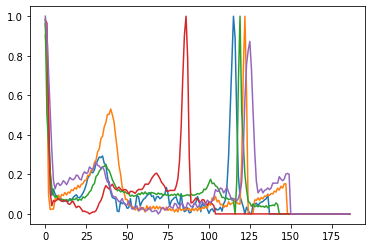

In [5]:
plt.plot(X[np.random.randint(0,100,5)].transpose())

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

# Model

The model is based on this article : https://arxiv.org/abs/1805.00794

In [124]:
from tensorflow.keras.layers import Input, Conv1D, MaxPool1D, Activation, Add, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

In [126]:
input_shape = (187, 1)

I = Input(input_shape)
C = Conv1D(filters=32, kernel_size=5)(I)

C11 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(C)
C12 = Conv1D(filters=32, kernel_size=5, padding='same')(C11)
A11 = Add()([C, C12])
R11 = Activation(activation='relu')(A11)
M11 = MaxPool1D(pool_size=5, strides=2)(R11)

C21 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(M11)
C22 = Conv1D(filters=32, kernel_size=5, padding='same')(C21)
A21 = Add()([M11, C22])
R21 = Activation(activation='relu')(A21)
M21 = MaxPool1D(pool_size=5, strides=2)(R21)

C31 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(M21)
C32 = Conv1D(filters=32, kernel_size=5, padding='same')(C31)
A31 = Add()([M21, C32])
R31 = Activation(activation='relu')(A31)
M31 = MaxPool1D(pool_size=5, strides=2)(R31)

C41 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(M31)
C42 = Conv1D(filters=32, kernel_size=5, padding='same')(C41)
A41 = Add()([M31, C42])
R41 = Activation(activation='relu')(A41)
M41 = MaxPool1D(pool_size=5, strides=2)(R41)

C51 = Conv1D(filters=32, kernel_size=5, activation='relu', padding='same')(M41)
C52 = Conv1D(filters=32, kernel_size=5, padding='same')(C51)
A51 = Add()([M41, C52])
R51 = Activation(activation='relu')(A51)
M51 = MaxPool1D(pool_size=5, strides=2)(R51)

F1 = Flatten()(M51)
D1 = Dense(32)(F1)
R1 = Activation(activation='relu')(D1)
D2 = Dense(32)(R1)
D3 = Dense(5)(D2)

O = Activation(activation='softmax')(D3)

model = Model(inputs=I, outputs=O)

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_99 (Conv1D)              (None, 183, 32)      192         input_10[0][0]                   
__________________________________________________________________________________________________
conv1d_100 (Conv1D)             (None, 183, 32)      5152        conv1d_99[0][0]                  
__________________________________________________________________________________________________
conv1d_101 (Conv1D)             (None, 183, 32)      5152        conv1d_100[0][0]                 
____________________________________________________________________________________________

"For training the networks, we used Adam optimization method with the learning rate, beta-1, and beta-2 of 0.001, 0.9, and 0.999, respectively. Learning rate is decayed exponentially with the decay factor of 0.75 every 10000 iterations."

In [127]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.001, decay_steps=10000, decay_rate=0.75)
adam = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [128]:
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [90]:
history = model.fit(np.expand_dims(X_train, axis=2), 
                    y_train, 
                    validation_split=0.15,
                    epochs = 5,
                    batch_size = 256)

Train on 79074 samples, validate on 13955 samples
Epoch 1/5
79074/79074 [==============================] - 82s 1ms/sample - loss: 0.0360 - acc: 0.9890 - val_loss: 0.0490 - val_acc: 0.9872
Epoch 2/5
79074/79074 [==============================] - 82s 1ms/sample - loss: 0.0311 - acc: 0.9904 - val_loss: 0.0458 - val_acc: 0.9871
Epoch 3/5
79074/79074 [==============================] - 81s 1ms/sample - loss: 0.0283 - acc: 0.9912 - val_loss: 0.0473 - val_acc: 0.9875
Epoch 4/5
79074/79074 [==============================] - 82s 1ms/sample - loss: 0.0263 - acc: 0.9917 - val_loss: 0.0482 - val_acc: 0.9870
Epoch 5/5
79074/79074 [==============================] - 82s 1ms/sample - loss: 0.0245 - acc: 0.9921 - val_loss: 0.0459 - val_acc: 0.9875


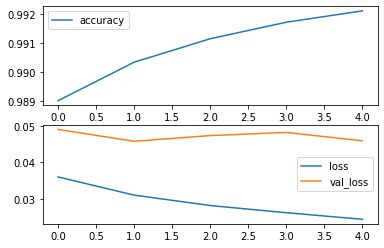

In [116]:
plt.subplot(211)
plt.plot(history.history['acc'])
plt.legend(["accuracy"])
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], label = "val_loss")
plt.legend(["loss", "val_loss"])
plt.show()

In [96]:
results = model.evaluate(np.expand_dims(X_test, axis=2), y_test, batch_size=128)

16417/16417 [==============================] - 7s 453us/sample - loss: 0.0535 - acc: 0.9857


In [118]:
labels = ["N", "S", "V", "F", "Q"]
raw_predictions = model.predict(np.expand_dims(X_test, axis=2), batch_size=128)
#predictions = [p['class_ids'][0] for p in raw_predictions]
#confusion_matrix = tf.confusion_matrix(labels, predictions)

In [122]:
raw_predictions.shape

(16417, 32)

In [121]:
tf.math.confusion_matrix(labels, raw_predictions)

ValueError: Can not squeeze dim[1], expected a dimension of 1, got 32 for 'confusion_matrix/remove_squeezable_dimensions/Squeeze' (op: 'Squeeze') with input shapes: [16417,32].